In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8

In [3]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        

In [20]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(gmm.means_), fontsize=(20))

In [5]:
def SelBest(arr:list, X:int)
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [7]:
data = pd.read_csv("../data/ageinc_g.csv", index_col = 0)
data.head()

,income,age,gender
0,101743,58,Female
1,49597,27,Female
2,36517,52,Male
3,33223,49,Male
4,72994,53,Female


In [8]:
mmScaler = MinMaxScaler()
mmScaler.fit(data[["income", "age"]]) 
data_mmscaler = mmScaler.transform(data[["income", "age"]])

In [9]:
temp = pd.DataFrame(data_mmscaler, columns = ["mm_income", "mm_age"])
data = pd.concat([data.reset_index(drop = True),
                    temp], axis = 1)

In [17]:
target_cols = ["mm_income", "mm_age"]
target_data = data[target_cols].to_numpy()

In [18]:
gmm=GMM(4).fit(target_data) 

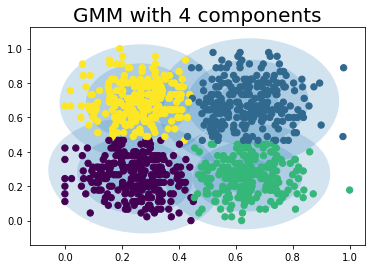

In [21]:
plot_gmm(gmm, target_data)

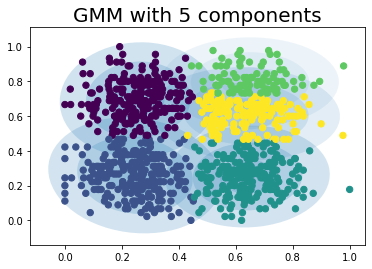

In [23]:
gmm=GMM(5).fit(target_data) 
plot_gmm(gmm, target_data)

## Method 1: Silohuette coefficient


In [28]:
n_clusters=np.arange(2, 8) # don't run n_cluster 1, cause it nonsense
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(target_data) 
        labels=gmm.predict(target_data)
        sil=metrics.silhouette_score(target_data, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

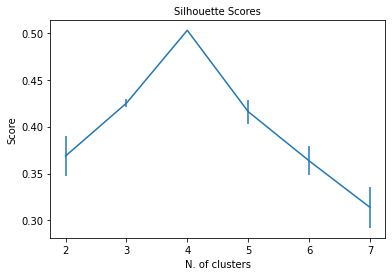

In [30]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=10)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

Choose the number of clusters is the best score: 4

In [39]:
optimal_n_cluster = n_clusters[sils.index(max(sils))]
print(f"optimal_n_cluster = {optimal_n_cluster}")

optimal_n_cluster = 4


## Method 2: Train - Test distance check

In [31]:
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [33]:
n_clusters=np.arange(2, 8)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    for iteration in range(iterations):
        train, test=train_test_split(target_data, test_size = 0.5)
        gmm_train=GMM(n, n_init=2).fit(train) 
        gmm_test=GMM(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

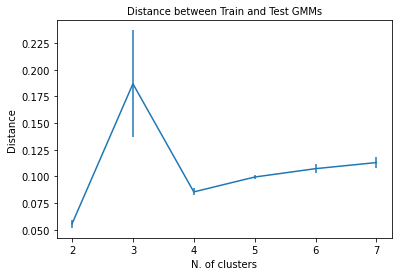

In [35]:
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=10)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

Choose the number of clusters is the minimum distance: 4

In [41]:
optimal_n_cluster = n_clusters[results.index(min(results))]
print(f"optimal_n_cluster = {optimal_n_cluster}")

optimal_n_cluster = 2


## Method 3: Bayesian information criterion (BIC)

In [36]:
n_clusters=np.arange(2, 8)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(target_data) 
        tmp_bic.append(gmm.bic(target_data))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

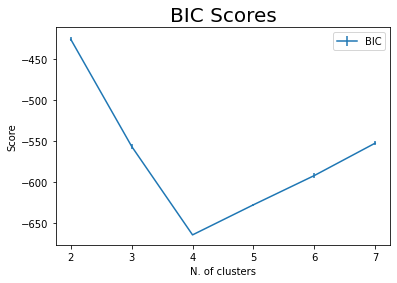

In [37]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

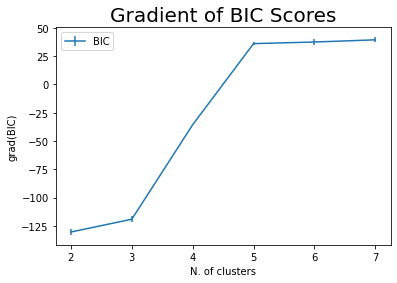

In [38]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

From a cluster size of 4 the gradient become almost constant
--> choose the 4 cluster

In [47]:
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

In [49]:
a = bics[0] - bics[-1]
b = n_clusters[-1] - n_clusters[0]
c1 = n_clusters[0] * bics[-1]
c2 = n_clusters[-1] * bics[0]
c = c1 - c2

In [50]:
distance_of_points_from_line = []
for k in range(len(n_clusters)):
  distance_of_points_from_line.append(
      calc_distance(n_clusters[k], bics[k], a, b, c))

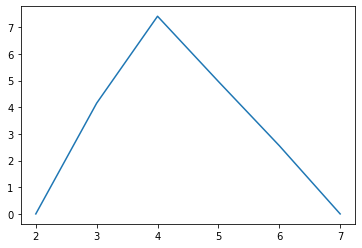

In [51]:
plt.plot(n_clusters, distance_of_points_from_line)

In [52]:
optimal_n_cluster = n_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print(f"optinal cluster is {optimal_n_cluster}")

optinal cluster is 4
